In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
import os

In [2]:
HOME = os.environ.get("HOME")
path_prefix = HOME + "/tracing/tracelog"
session_name = "session-20220704201438"
path_tracelog = os.path.join(path_prefix, session_name + '.txt')
path_start = os.path.join(path_prefix, session_name + '_cstart.txt')
path_end = os.path.join(path_prefix, session_name + '_cend.txt')

path = path_tracelog
f = open(path)
f.close()
with open(path) as f:
    l = f.readlines()

HEADER_PUBLISHERS_E  = 'Publishers:\n' if 'Publishers:\n' in l else 'Publishers (rmw):\n'
HEADER_PUBLISHERS_S  = 'Publishers:\n' if 'Publishers:\n' in l else 'Publishers (rcl):\n'
HEADER_SUBSCRIBERS_E = 'Subscriptions:\n' if 'Subscriptions:\n' in l else 'Subscriptions (rmw):\n'
HEADER_SUBSCRIBERS_S = 'Subscriptions:\n' if 'Subscriptions:\n' in l else 'Subscriptions (rcl):\n'
S = l.index('Nodes:\n')
E_rmw = l.index(HEADER_PUBLISHERS_E)
E = l.index(HEADER_PUBLISHERS_S)
no=[]
for i in l[S+3:E_rmw-1]:
    no.append(i.split()[4])

In [3]:
import os
dirname = os.path.join(path_prefix, session_name, "out")
os.makedirs(dirname, exist_ok=True)

#plot a label as ms
def label(latency):
    return 'max:{:.02f}ms, mean:{:.02f}ms'.format(max(latency),np.mean(latency))
#plot a graph as ms
def graph(latency, title):
    fig, ax = plt.subplots(1, 1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.hist(latency, bins=200, label=label(latency))
    plt.legend()
    plt.title("%s"%title, fontsize=15)
    plt.xlabel("Latency [ms]", fontsize=15)
    plt.ylabel("Sample", fontsize=15)
    filename = dirname + "%s"%title+".pdf"
    plt.savefig(filename)

#plot a label as us
def label2(latency):
    return 'max:{:.02f}us, mean:{:.02f}us'.format(max(latency),np.mean(latency))
#plot a graph
def graph2(latency, title):
    fig, ax = plt.subplots(1, 1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.hist(latency, bins=200, label=label2(latency))
    plt.legend()
    plt.title("%s"%title, fontsize=15)
    plt.xlabel("Latency [us]", fontsize=15)
    plt.ylabel("Sample", fontsize=15)
    filename = dirname + "%s"%title+".pdf"
    plt.savefig(filename)

In [4]:
# get callback in XXX node
def cb(node):    
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    #node handle
    S = l.index('Nodes:\n')
    E = l.index(HEADER_PUBLISHERS_E)
    nodel = [line for line in l[S:E] if node in line]
    nodename= nodel[0].split()[4]
    nodeh= nodel[0].split()[0]

    S = l.index(HEADER_SUBSCRIBERS_S)
    E = l.index('Subscription objects:\n')
    subt = [line for line in l[S:E] if nodeh in line]
    stopic=[]
    for i in subt:
        stopic.append('/'+i.split(' /')[1].split()[0])
    print('sub:',stopic)
    
    S = l.index(HEADER_PUBLISHERS_S)
    E = l.index(HEADER_SUBSCRIBERS_E)
    pubt = [line for line in l[S:E] if nodeh in line]
    ptopic=[]
    for i in pubt:
        ptopic.append('/'+i.split(' /')[1].split()[0])
    print('pub:',ptopic)
    
    S = l.index('Services:\n')
    E = l.index('Clients:\n')
    sert = [line for line in l[S:E] if nodeh in line]
    sname=[]
    for i in sert:
        sname.append('/'+i.split(' /')[1].split()[0])
    #print('service:',sname)
    
    S = l.index('Clients:\n')
    E = l.index('Timers:\n')
    clit = [line for line in l[S:E] if nodeh in line]
    csname=[]
    for i in clit:
        csname.append('/'+i.split(' /')[1].split()[0])
    #print('client:',csname)

def cbname(node,topic):
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    
    #node handle
    S = l.index('Nodes:\n')
    E = l.index(HEADER_PUBLISHERS_E)
    node = [line for line in l[S:E] if node in line]
    nodename= node[0].split()[4]
    nodeh= node[0].split()[0]

    S = l.index(HEADER_SUBSCRIBERS_S)
    E = l.index('Subscription objects:\n')
    subt = [line for line in l[S:E] if nodeh in line]
    st=[line for line in subt if topic in line]
    #print(st)
    subscription_handle=st[0].split()[0]
    
    #subscription_handle -> reference
    S = l.index('Subscription objects:\n')
    E = l.index('Services:\n')   
    refer=[]
    ref = [line for line in l[S:E] if subscription_handle in line]
    refer.append(''.join(ref))
    reference= refer[0].split()[0]
    
    #reference -> callback_object
    S = l.index('Callback objects:\n')
    E = l.index('Callback symbols:\n')   
    cboj=[]
    cb= [line for line in l[S:E] if reference in line]
    cboj.append(''.join(cb))
    callback_object=cboj[0].split()[2]
    cbh = str(hex(int(callback_object)))
    cbhandle = cbh.upper().replace('X', 'x')

    return cbhandle

# get callback duration
def cbd(node, topic, title=''):
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    
    #node handle
    S = l.index('Nodes:\n')
    E = l.index(HEADER_PUBLISHERS_E)
    node = [line for line in l[S:E] if node in line]
    nodename= node[0].split()[4]
    nodeh= node[0].split()[0]
    S = l.index(HEADER_SUBSCRIBERS_S)
    E = l.index('Subscription objects:\n')
    subt = [line for line in l[S:E] if nodeh in line]
    st=[line for line in subt if topic in line]
    subscription_handle= st[0].split()[0]
    
    #subscription_handle -> reference
    S = l.index('Subscription objects:\n')
    E = l.index('Services:\n')   
    refer=[]
    ref = [line for line in l[S:E] if subscription_handle in line]
    refer.append(''.join(ref))
    reference= refer[0].split()[0]
    
    #reference -> callback_object
    S = l.index('Callback objects:\n')
    E = l.index('Callback symbols:\n')   
    cboj=[]
    cb= [line for line in l[S:E] if reference in line]
    cboj.append(''.join(cb))
    callback_object=cboj[0].split()[2]

    t=[]
    S = l.index('Callback instances:\n')
    E = l.index('Lifecycle state machines:\n')  
    l_XXX = [line for line in l[S:E] if callback_object in line]

    cbd_ns = []
    for i in l_XXX:
        cbd_ns.append(int(i.split()[6].split('.')[1])) 
    cbd_us = []
    for i in cbd_ns:
        cbd_us.append(i/1000)
    
    for i in cbd_us:
        if i > 200000:
            cbd_us.remove(i)
            
    _title = title if title else nodename

    return cbd_us,_title

# get callback duration
def t_cbd(node, title=''):
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    
    #node handle
    S = l.index('Nodes:\n')
    E = l.index(HEADER_PUBLISHERS_E)
    node = [line for line in l[S:E] if node in line]
    nodename= node[0].split()[4]
    nodeh= node[0].split()[0]
    S = l.index(HEADER_SUBSCRIBERS_S)
    E = l.index('Subscription objects:\n')
    # subt = [line for line in l[S:E] if nodeh in line]
    # st=[line for line in subt if topic in line]
    # subscription_handle= st[0].split()[0]
    
    #nodeh -> timer_handle
    S = l.index('Timer-node links:\n')
    E = l.index('Callback objects:\n')
    refer=[]
    ref = [line for line in l[S:E] if nodeh in line]
    refer.append(''.join(ref))
    reference= refer[0].split()[0]
    
    #reference -> callback_object
    S = l.index('Callback objects:\n')
    E = l.index('Callback symbols:\n')   
    cboj=[]
    cb= [line for line in l[S:E] if reference in line]
    cboj.append(''.join(cb))
    callback_object=cboj[0].split()[2]

    t=[]
    S = l.index('Callback instances:\n')
    E = l.index('Lifecycle state machines:\n')  
    l_XXX = [line for line in l[S:E] if callback_object in line]

    cbd_ns = []
    for i in l_XXX:
        cbd_ns.append(int(i.split()[6].split('.')[1])) 
    cbd_us = []
    for i in cbd_ns:
        cbd_us.append(i/1000)
    
    for i in cbd_us:
        if i > 200000:
            cbd_us.remove(i)
            
    _title = title if title else nodename

    return cbd_us,_title

def com_latency(callback1,callback2):
    path = path_end
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    
    com1_latency = []
    for i in l:
        cb1 = i.split("callback = ")[1].split(" }")[0]
        if (cb1 == callback1):
            com1 = int(i.split('+0.')[1].split(')')[0])
            com1_latency.append(com1)
            
    path = path_start
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    
    com2_latency = []
    for i in l:
        cb2 = i.split("callback = ")[1].split(",")[0]
        if (cb2 == callback2):
            com2 = int(i.split('+0.')[1].split(')')[0])
            com2_latency.append(com2)
    
    com_latency=[com1_latency[i]+com2_latency[i] for i in range(min(len(com1_latency),len(com2_latency)))]

    com_latency_us = []
    for i in com_latency:
        com_latency_us.append(i/1000)
    return com_latency_us

In [5]:
node_gps = 'global_parameters_node'
node_ssm = 'system_status_manager_node'
node_msm = 'mission_manager_node'
node_odi = 'override_device_interface_node'
node_rci = 'rc_interface_node'
node_awl = 'aw_localization_node'
# node_geo = 'localization_geofence_node'
# node_res = 'localization_resilient_node'
# node_map = 'localization_globalmap_node'
node_wpt = 'waypoint_manager_node_mission_selective'
node_dyn = 'dynamic_planning_node'
node_vel = 'velocity_planning_node'
node_acc = 'nif_idm_based_acc_node'
node_lqr = 'control_joint_lqr'
node_csl = 'control_safety_layer_node'
node_acn = 'AccelControlNode'
# node_dbw = 'raptor_dbw_can_node'
# node_ssc = 'ssc_interface_node'
node_clu = 'lidar_clustering_node'
node_trc = 'objects_tracking_node'
node_cnc = 'perception_concat_node'
node_pre = 'opponent_predictor_node'
node_gff = 'geofence_filter_node'
node_urd = 'robot_state_publisher'

In [6]:
# cb(node_awl)
# cb(node_ssm)
# cb(node_msm)
# cb(node_odi)
# cb(node_rci)
# cb(node_geo)
# cb(node_res)
# cb(node_map)
# cb(node_wpt)
# cb(node_dyn)
# cb(node_vel)
# cb(node_acc)
# cb(node_lqr)
cb(node_csl)
# cb(node_acn)
# cb(node_clu)
# cb(node_dbw)
# cb(node_ssc)

sub: ['/parameter_events', '/aw_localization/ekf/odom', '/system/status', '/raptor_dbw_interface/pt_report', '/control_pool/control_cmd', '/control_pool/override_cmd', '/raptor_dbw_interface/wheel_speed_report', '/raptor_dbw_interface/pt_report', '/no_0', '/no_1', '/no_2']
pub: ['/rosout', '/parameter_events', '/node_status/control_safety_layer_node', '/control_safety_layer/out/control_cmd', '/joystick/steering_cmd', '/joystick/accelerator_cmd', '/joystick/brake_cmd', '/joystick/gear_cmd', '/control_safety_layer/out/desired_accel', '/diagnostics/heartbeat']


In [7]:
topic_ss = '/system/status'
topic_sm = '/system/mission'
topic_ns_csl = '/node_status/control_safety_layer_node'
topic_ns_acc = '/node_status/nif_idm_based_acc_node'
topic_ns_vel = '/node_status/velocity_planning_node'
topic_ns_awl = '/node_status/aw_localization_node'
topic_ns_lqr = '/node_status/control_joint_lqr'
topic_ns_dyn = '/node_status/dynamic_planning_node'
topic_ns_wpt = '/node_status/waypoint_manager_node_mission_selective'
topic_ns_msm = '/node_status/mission_manager_node'
topic_ns_gff = '/node_status/geofence_filter_node'
# topic_ns_res = '/node_status/localization_resilient_node'

topic_veh_ejy = '/vehicle/emergency_joystick'
topic_veh_ehb = '/vehicle/emergency_heartbeat'

topic_joy_acc = '/joystick/accelerator_cmd'
topic_joy_brk = '/joystick/brake_cmd'
topic_joy_gea = '/joystick/gear_cmd'
topic_joy_str = '/joystick/steering_cmd'

topic_csl_out_cmd = '/control_safety_layer/out/control_cmd'
topic_csl_out_dac = '/control_safety_layer/out/desired_accel'

topic_cpool_ovr = '/control_pool/override_cmd'
topic_cpool_cmd = '/control_pool/control_cmd'

topic_acc_acc = '/control/acc/des_acc'
topic_vel_vel = '/velocity_planner/des_vel'
topic_awl_odo = '/aw_localization/ekf/odom'
topic_awl_err = '/aw_localization/ekf/error'
topic_awl_sts = '/aw_localization/ekf/status'

topic_perc_concat = '/perception/concat'
topic_perc_clu_pl = '/clustered/perception_list'
topic_perc_esr_track = '/radar_front/esr_track'

topic_rci_rfs = '/rc_interface/rc_flag_summary'
topic_pla_glo = '/planning/path_global'
topic_dyn_glo = '/planning/dynamic/traj_global'
topic_hb = '/diagnostics/heartbeat'
topic_clu_cp = '/cluster_center_points'
topic_tf = '/tf'

topic_sen_gnss_top = '/novatel_top/bestgnsspos'

In [8]:
tasks_cb = {
    "state_estimation" : [
        (node_awl,topic_sen_gnss_top),
    ],

    "perception" : [
        (node_clu, ),
        (node_trc, topic_perc_concat),
        (node_cnc, ),
        # (node_pre, ), # Missing data in the tracing session
        (node_gff, topic_perc_clu_pl),
    ],

    "planning" : [
        (node_wpt, ),
        (node_dyn, ),
        (node_vel, ),
    ],

    "control" : [
        (node_acc, ),
        (node_lqr, ),
        (node_csl, ),
        # (node_acn, topic_csl_out_dac),
    ]
}

In [9]:
cb1 = cbname(node_awl,topic_sen_gnss_top)
cb2 = cbname(node_dyn,topic_awl_odo)
cb3 = cbname(node_lqr,topic_dyn_glo)
cb4 = cbname(node_csl,topic_cpool_cmd)
cb5 = cbname(node_acn,topic_csl_out_dac)
# cb6 = cbname(node_ssc,topic_joy_acc)
# cb7 = cbname(node7,topic7)
# cb8 = cbname(node8,topic8)
# cb9 = cbname(node9,topic9)
# cb10 = cbname(node10,topic10)
# cb11 = cbname(node11,topic11)
# cb12 = cbname(node12,topic12)
# cb13 = cbname(node13,topic13)
# cb14 = cbname(node14,topic14)
# cb15 = cbname(node15,topic15)
# cb16 = cbname(node16,topic16)

IndexError: list index out of range

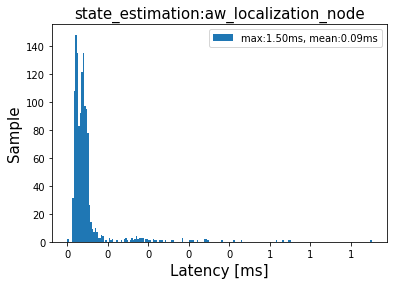

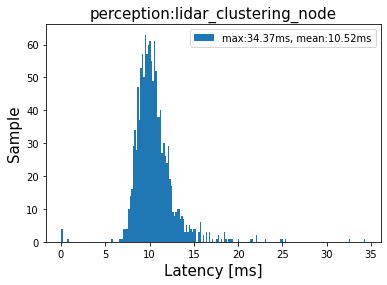

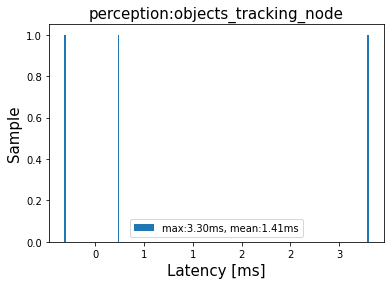

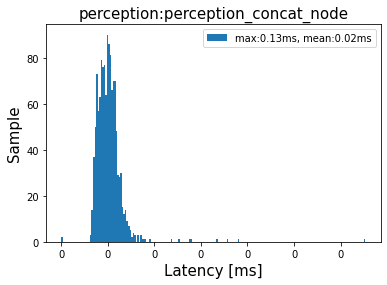

In [10]:
for task in tasks_cb:
    for step in tasks_cb[task]:
        if len(step) >= 2:
            cbduration,_title = cbd(step[0], step[1])
        else:
            cbduration,_title = t_cbd(step[0])

        title = task + ':' + _title
        len(cbduration)
        cbduration_ms=[i/1000 for i in cbduration]
        graph(cbduration_ms,title)

1286

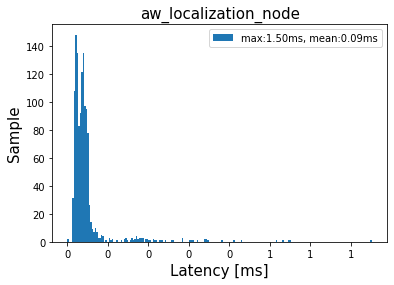

In [ ]:
cbduration1,title = cbd(node_awl,topic_sen_gnss_top)
cbduration1_ms=[i/1000 for i in cbduration1]
graph(cbduration1_ms,title)
len(cbduration1)

1286

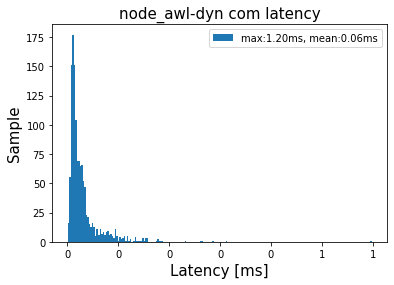

In [ ]:
comlatency12=com_latency(cb1,cb2)
title='node_awl-dyn com latency'
comlatency12_ms=[i/1000 for i in comlatency12]
graph(comlatency12_ms,title)
len(comlatency12)

5241

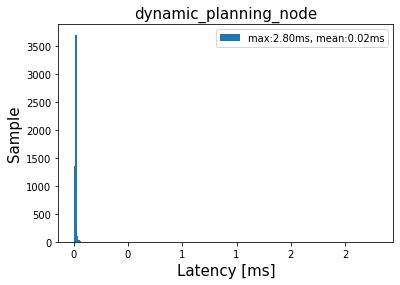

In [ ]:
cbduration2,title = cbd(node_dyn, topic_awl_odo)
cbduration2_ms=[i/1000 for i in cbduration2]
graph(cbduration2_ms,title)
len(cbduration2)

2621

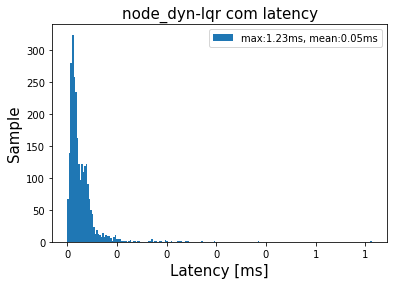

In [ ]:
comlatency23=com_latency(cb2,cb3)
comlatency23_ms=[i/1000 for i in comlatency23]
title='node_dyn-lqr com latency'
graph(comlatency23_ms,title)
len(comlatency23)

2621

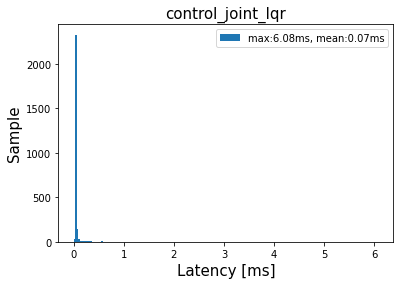

In [ ]:
cbduration3,title = cbd(node_lqr,topic_dyn_glo)
cbduration3_ms=[i/1000 for i in cbduration3]
graph(cbduration3_ms,title)
len(cbduration3)

ValueError: max() arg is an empty sequence

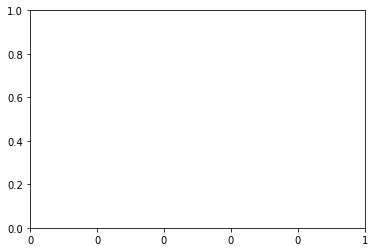

In [ ]:
comlatency34=com_latency(cb3,cb4)
title='node_lqr-csl com latency'
comlatency34_ms=[i/1000 for i in comlatency34]
graph(comlatency34_ms,title)
len(comlatency34)

ValueError: max() arg is an empty sequence

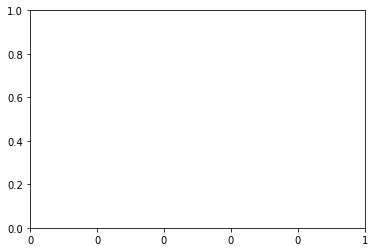

In [ ]:
cbduration4,title = cbd(node_csl,topic_cpool_cmd)
cbduration4_ms=[i/1000 for i in cbduration4]
graph(cbduration4_ms,title)
len(cbduration4)

ValueError: max() arg is an empty sequence

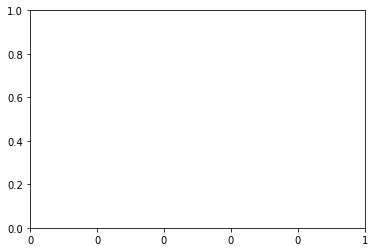

In [ ]:
comlatency45=com_latency(cb4,cb5)
title='node4-5 com latency'
comlatency45_ms=[i/1000 for i in comlatency45]
graph(comlatency45_ms,title)
len(comlatency45)

ValueError: max() arg is an empty sequence

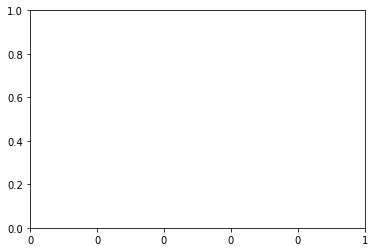

In [ ]:
cbduration5,title = cbd(node_acn,topic_csl_out_dac)
cbduration5_ms=[i/1000 for i in cbduration5]
graph(cbduration5_ms,title)
len(cbduration5)

In [ ]:
comlatency56=com_latency(cb5,cb6)
title='node5-6 com latency'
comlatency56_ms=[i/1000 for i in comlatency56]
graph(comlatency56_ms,title)
len(comlatency56)

NameError: name 'cb6' is not defined

In [ ]:
cbduration6,title = cbd(node_ssc,topic_joy_acc)
cbduration6_ms=[i/1000 for i in cbduration6]
graph(cbduration6_ms,title)
len(cbduration6)

IndexError: list index out of range

In [ ]:
comlatency67=com_latency(cb6,cb7)
title='node6-7 com latency'
comlatency67_ms=[i/1000 for i in comlatency67]
graph(comlatency67_ms,title)
len(comlatency67)

In [ ]:
cbduration7,title = cbd(node7,topic7)
cbduration7_ms=[i/1000 for i in cbduration7]
graph(cbduration7_ms,title)
len(cbduration7)

In [ ]:
comlatency78=com_latency(cb7,cb8)
title='node7-8 com latency'
comlatency78_ms=[i/1000 for i in comlatency78]
graph(comlatency78_ms,title)
len(comlatency78)

In [ ]:
cbduration8,title = cbd(node8,topic8)
cbduration8_ms=[i/1000 for i in cbduration8]
graph(cbduration8_ms,title)
len(cbduration8)

In [ ]:
comlatency89=com_latency(cb8,cb9)
title='node8-9 com latency'
comlatency89_ms=[i/1000 for i in comlatency89]
graph(comlatency89_ms,title)
len(comlatency89)

In [ ]:
cbduration9,title = cbd(node9,topic9)
cbduration9_ms=[i/1000 for i in cbduration9]
graph(cbduration9_ms,title)
len(cbduration9)

In [ ]:
comlatency910=com_latency(cb9,cb10)
title='node9-10 com latency'
comlatency910_ms=[i/1000 for i in comlatency910]
graph(comlatency910_ms,title)
len(comlatency910)

In [ ]:
cbduration10,title = cbd(node10,topic10)
cbduration10_ms=[i/1000 for i in cbduration10]
graph(cbduration10_ms,title)
len(cbduration10)

In [ ]:
comlatency1011=com_latency(cb10,cb11)
title='node10-11 com latency'
comlatency1011_ms=[i/1000 for i in comlatency1011]
graph(comlatency1011_ms,title)
len(comlatency1011_ms)

In [ ]:
cbduration11,title = cbd(node11,topic11)
cbduration11_ms=[i/1000 for i in cbduration11]
graph(cbduration11_ms,title)
len(cbduration11)

In [ ]:
comlatency1112=com_latency(cb11,cb12)
title='node11-12 com latency'
comlatency1112_ms=[i/1000 for i in comlatency1112]
graph(comlatency1112_ms,title)
len(comlatency1112)

In [ ]:
cbduration12,title = cbd(node12,topic12)
cbduration12_ms=[i/1000 for i in cbduration12]
graph(cbduration12_ms,title)
len(cbduration12)

In [ ]:
comlatency1213=com_latency(cb12,cb13)
title='node12-13 com latency'
comlatency1213_ms=[i/1000 for i in comlatency1213]
graph(comlatency1213_ms,title)
len(comlatency1213)

In [ ]:
cbduration13,title = cbd(node13,topic13)
cbduration13_ms=[i/1000 for i in cbduration13]
graph(cbduration13_ms,title)
len(cbduration13)

In [ ]:
comlatency1314=com_latency(cb13,cb14)
title='node13-14 com latency'
comlatency1314_ms=[i/1000 for i in comlatency1314]
graph(comlatency1314_ms,title)
len(comlatency1314)

In [ ]:
cbduration14,title = cbd(node14,topic14)
cbduration14_ms=[i/1000 for i in cbduration14]
graph(cbduration14_ms,title)
len(cbduration14)

In [ ]:
comlatency1415=com_latency(cb14,cb15)
title='node14-15 com latency'
comlatency1415_ms=[i/1000 for i in comlatency1415]
graph(comlatency1415_ms,title)
len(comlatency1415)

In [ ]:
cbduration15,title = cbd(node15,topic15)
cbduration15_ms=[i/1000 for i in cbduration15]
graph(cbduration15_ms,title)
len(cbduration15)

In [ ]:
comlatency1516=com_latency(cb15,cb16)
title='node15-16 com latency'
comlatency1516_ms=[i/1000 for i in comlatency1516]
graph(comlatency1516_ms,title)
len(comlatency1516)

In [ ]:
cbduration16,title = cbd(node16,topic16)
cbduration16_ms=[i/1000 for i in cbduration16]
graph(cbduration16_ms,title)
len(cbduration16)

In [ ]:
# n1 = [int(cbduration1[i]+cbduration2[i]+cbduration3[i]+cbduration4[i]+cbduration5[i]+cbduration8[i]+cbduration9[i]+cbduration10[i]+cbduration11[i]+cbduration12[i]+cbduration13[i]+cbduration14[i]+cbduration15[i]) for i in range(min(len(cbduration1),len(cbduration2),len(cbduration3),len(cbduration4),len(cbduration5),len(cbduration8),len(cbduration9),len(cbduration10),len(cbduration11),len(cbduration12),len(cbduration13),len(cbduration14),len(cbduration15)))]
# c1 = [int(comlatency12[i]+comlatency23[i]+comlatency34[i]+comlatency45[i]+comlatency56[i]+comlatency78[i]+comlatency89[i]+comlatency910[i]+comlatency1011[i]+comlatency1112[i]+comlatency1213[i]+comlatency1314[i]+comlatency1415[i]+comlatency1516[i]) for i in range(min(len(comlatency12),len(comlatency23),len(comlatency34),len(comlatency45),len(comlatency56),len(comlatency78),len(comlatency89),len(comlatency910),len(comlatency1011),len(comlatency1112),len(comlatency1213),len(comlatency1314),len(comlatency1415),len(comlatency1516)))]
# p1 = [int(n1[i]+c1[i]) for i in range(min(len(n1),len(c1)))]

# n2 = [int(cbduration6[i]+cbduration7[i]+cbduration16[i]) for i in range(min(len(cbduration6),len(cbduration7),len(cbduration16)))]
# c2 = [int(comlatency67[i]) for i in range(len(comlatency67))]
# p2 = [int(n2[i]+c2[i]) for i in range(min(len(n2),len(c2)))]

n1 = [int(cbduration1[i]+cbduration2[i]+cbduration3[i]) for i in range(min(len(cbduration1),len(cbduration2),len(cbduration3)))]
c1 = [int(comlatency12[i]+comlatency23[i]) for i in range(min(len(comlatency12),len(comlatency23)))]
p1 = [int(n1[i]+c1[i]) for i in range(min(len(n1),len(c1)))]

n2 = [int(cbduration6[i]+cbduration5[i]+cbduration4[i]) for i in range(min(len(cbduration6),len(cbduration5),len(cbduration4)))]
c2 = [int(comlatency45[i]) for i in range(len(comlatency45))]
p2 = [int(n2[i]+c2[i]) for i in range(min(len(n2),len(c2)))]

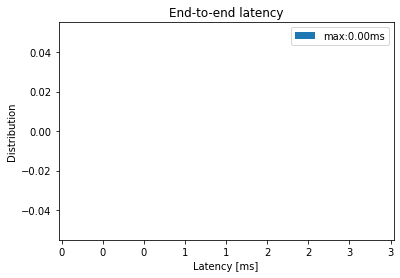

In [ ]:
# convolution integral
import numpy as np
import matplotlib.pyplot as plt
def convo(p1,p2):
    bin=50
    x1= np.arange(bin, max(p1) + bin, bin)
    #print(x1,len(x1))
    x2= np.arange(bin, max(p2) + bin, bin)
    #print(x2,len(x2))
    if len(x1) > len(x2):
        x=x1
    else:
        x=x2
    
    #P1
    P1=[]
    for i in x:
        l=0
        for j in p1:
            if (j < i)&(j > i-bin):
                l+=1
        l/= len(p1)
        P1.append(l)

    #P2
    P2=[]
    for i in x:
        l=0
        for j in p2:
            if (j < i)&(j > i-bin):
                l+=1
        l/= len(p2)
        P2.append(l)
    
    #P1+P2
    P = [] 
    for i in range(len(x)):
        p12 = 0
        for t in range(i):
            p12+= P1[t]*(P2[i-t] + P2[i-t-1])/2.0        
        P.append(p12)
    return x,P

x,p=convo(p1,p2)
x_ms=[i/1000 for i in x]
m=[]
j=0
for i in p:
    j+=50
    if i > 0:
        m.append(j)
maxinum=max(m)/1000

fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('End-to-end latency')
plt.xlabel('Latency [ms]')
plt.ylabel('Distribution')
plt.bar(x_ms,p,label='max:{:.02f}ms'.format(maxinum))
plt.legend()
filename = dirname + "e2elatency.pdf"
plt.savefig(filename)

In [ ]:
# a=0
# for i in p:
#     a+=i
# r=int(100000/50)
# k=0
# for i in range(r):
#     k+=p[i]
# k/a

In [ ]:
#service pair
def pair():
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    S = l.index('Services:\n')
    E = l.index('Clients:\n')
    service_sn=[]
    for i in l[S+3:E-1]:
        service_sn.append(i.split()[4])
    #print(set(service_sn))
    
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    S = l.index('Clients:\n')
    E = l.index('Timers:\n')
    client_sn=[]
    for i in l[S+3:E-1]:
        client_sn.append(i.split()[4])
    #print(set(client_sn))
    
    for i in service_sn:
        for j in client_sn:
            if i == j:
                print(i)
pair()

/global_parameters_node/get_parameters
/global_parameters_node/get_parameters
/global_parameters_node/get_parameters
/global_parameters_node/get_parameters
/global_parameters_node/get_parameters
/global_parameters_node/get_parameters
/global_parameters_node/get_parameters
/global_parameters_node/get_parameters
/global_parameters_node/get_parameters
/global_parameters_node/get_parameter_types
/global_parameters_node/get_parameter_types
/global_parameters_node/get_parameter_types
/global_parameters_node/get_parameter_types
/global_parameters_node/get_parameter_types
/global_parameters_node/get_parameter_types
/global_parameters_node/get_parameter_types
/global_parameters_node/get_parameter_types
/global_parameters_node/get_parameter_types
/global_parameters_node/set_parameters
/global_parameters_node/set_parameters
/global_parameters_node/set_parameters
/global_parameters_node/set_parameters
/global_parameters_node/set_parameters
/global_parameters_node/set_parameters
/global_parameters_

In [ ]:
#service latency
client_req = 837111312
service_req= 837568907
service_res= 837667763
client_res = 839947678

requestlatency=(service_req-client_req)/1000000
servicecallback=(service_res-service_req)/1000000
responselatency=(client_res-service_res)/1000000
servicelatency=requestlatency+servicecallback+responselatency
print(requestlatency,'ms')
print(servicecallback,'ms')
print(responselatency,'ms')
print(servicelatency,'ms')

0.457595 ms
0.098856 ms
2.279915 ms
2.836366 ms
